# eBOSS Quasar Luminosity Function Fitting

In [1]:
import corner
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Math
from astropy.cosmology import Planck15

from conf import PATHEXT, PATHIN, PATHOUT
from horizonground.lumfunc_likelihood import LumFuncLikelihood, LumFuncMeasurements
from horizonground.lumfunc_modeller import (
    LumFuncModeller, konstante_correction, quasar_PLE_lumfunc, quasar_hybrid_lumfunc
)
from horizonground.utils import process_header

## eBOSS QSO luminosity function data

In [2]:
luminosity_function_data = LumFuncMeasurements(
    PATHEXT/"eBOSS_QSO_LF_measurements.txt", PATHEXT/"eBOSS_QSO_LF_uncertainties.txt", 
    base10_log=False
)

In [3]:
magnitude_bins = luminosity_function_data.luminosity_bins
redshift_bins = luminosity_function_data.redshift_bins
redshift_labels = luminosity_function_data.redshift_labels

## QSO luminosity function fitted models

In [4]:
reference_model = LumFuncModeller.from_parameter_file(
    parameter_file=PATHIN/"cabinet"/"QSO_LF_PLE_model_fixed.txt",
    model_lumfunc=quasar_PLE_lumfunc,
    luminosity_variable='magnitude',
    threshold_value=22.5,
    cosmology=Planck15    
)

In [5]:
refitted_model = LumFuncModeller.from_parameter_file(
    parameter_file=PATHIN/"cabinet"/"QSO_LF_PLE_model_poisson.txt",
    model_lumfunc=quasar_PLE_lumfunc,
    luminosity_variable='magnitude',
    threshold_value=22.5,
    cosmology=Planck15    
)

## QSO luminosity function fitted model $\chi^2$ comparison

In [6]:
lglumfunc_loglikelihood = LumFuncLikelihood(
    quasar_PLE_lumfunc,
    measurement_file=PATHEXT/"eBOSS_QSO_LF_measurements.txt",
    uncertainty_file=PATHEXT/"eBOSS_QSO_LF_uncertainties.txt",
    prior_file=PATHIN/"QSO_LF_PLE_model_prior.txt",
    prescription='symlg'
)

dof = len(lglumfunc_loglikelihood.data_vector) - len(lglumfunc_loglikelihood.prior)

chisq_poisson_fit = - 2 * lglumfunc_loglikelihood(refitted_model.attrs['model_parameters'].values())
display(Math(
    r"\text{{refitted model (Poisson): }} \chi^2 = {:.3f}/{} = {:.5f}".
    format(chisq_poisson_fit, dof, chisq_poisson_fit / dof)
))

<IPython.core.display.Math object>

In [7]:
lumfunc_loglikelihood = LumFuncLikelihood(
    quasar_PLE_lumfunc,
    measurement_file=PATHEXT/"eBOSS_QSO_LF_measurements.txt",
    uncertainty_file=PATHEXT/"eBOSS_QSO_LF_uncertainties.txt",
    prior_file=PATHIN/"QSO_LF_PLE_model_prior.txt",
    prescription='native'
)

dof = len(lumfunc_loglikelihood.data_vector) - len(lumfunc_loglikelihood.prior)

chisq_poisson_fit = - 2 * lumfunc_loglikelihood(refitted_model.attrs['model_parameters'].values())
display(Math(
    r"\text{{refitted model (Poisson): }} \chi^2 = {:.3f}/{} = {:.5f}".
    format(chisq_poisson_fit, dof, chisq_poisson_fit / dof)
))

<IPython.core.display.Math object>

## eBoss QSO luminosity function sampled models

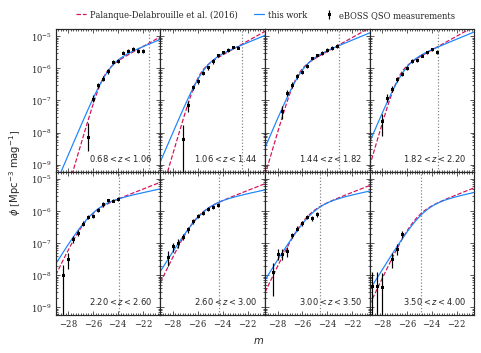

In [8]:
MAGNITUDE_RANGE = -29.0, -20.6
DENSITY_RANGE = pow(10, -9.225), pow(10, -4.775)
NUM_INTERVALS = 100

m = np.linspace(*MAGNITUDE_RANGE, num=NUM_INTERVALS+1)

NUM_ROW, NUM_COL = 2, 4
ROW_SPAN, COL_SPAN = 4, 3

fig = plt.figure(figsize=(7.5, 5.25))
for bin_idx, redshift in enumerate(redshift_bins):
    # Set up subplots.
    row_idx, col_idx = bin_idx // NUM_COL, bin_idx % NUM_COL
    
    ax = plt.subplot2grid(
        (NUM_ROW * ROW_SPAN, NUM_COL * COL_SPAN), (row_idx * ROW_SPAN, col_idx * COL_SPAN), 
        rowspan=ROW_SPAN, colspan=COL_SPAN
    )
    
    # Plot data and models.
    data_values, data_errors = luminosity_function_data[bin_idx]
    data_errs = luminosity_function_data._errors[bin_idx]
    if bin_idx == 0:
        plt.errorbar(
            magnitude_bins, data_values, yerr=[data_errs, data_errors],
            fmt='s', zorder=3, label='eBOSS QSO measurements'
        )
        plt.plot(
            m, reference_model.luminosity_function(m, redshift),
            ls='--', c='#D41159', zorder=2, label='Palanque-Delabrouille et al. (2016)'
        )
        plt.plot(
            m, refitted_model.luminosity_function(m, redshift),
            c='#1A85FF', zorder=2, label='this work'
        )
    else:
        plt.errorbar(
            magnitude_bins, data_values, data_errors,
            fmt='s', zorder=3,
        )
        plt.plot(m, reference_model.luminosity_function(m, redshift), ls='--', c='#D41159', zorder=2)
        plt.plot(m, refitted_model.luminosity_function(m, redshift), c='#1A85FF', zorder=2)
    
    plt.axvline(
        refitted_model.luminosity_threshold(redshift) - konstante_correction(redshift),
        ls=':', c='0.5', zorder=1
    )
                
    # Set up axes.
    plt.xscale('linear')
    plt.xlim(*MAGNITUDE_RANGE)
    
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2.))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))
    if row_idx + 1 < NUM_ROW:
        plt.tick_params(axis='x', which='both', direction='in', labelbottom=False)
    
    plt.yscale('log')    
    plt.ylim(*DENSITY_RANGE)
    
    if col_idx > 0:
        plt.tick_params(axis='y', which='both', direction='in', labelleft=False)
    
    plt.title(
        redshift_labels[bin_idx], loc='right', position=(0.925, 0.025), 
        fontsize='small', zorder=2
    )

lines, labels = [], []
for ax in fig.axes:
    ax_line, ax_label = ax.get_legend_handles_labels()
    lines.extend(ax_line)
    labels.extend(ax_label)

plt.figtext(0.5, 0.0475, r"$m$", ha='center')
plt.figtext(
    0.035, 0.5, r"$\phi$ [$\mathrm{Mpc}^{-3}\ \mathrm{mag}^{-1}$]", va='center', rotation='vertical'
)    
plt.legend(
    lines, labels, ncol=3, handlelength=1.2, handletextpad=0.5,
    bbox_to_anchor=(-1., 2.1), loc='center'
)

plt.subplots_adjust(hspace=0, wspace=0)
fig.savefig(PATHOUT/"publication"/"gallery"/"luminosity_function.pdf")